In [1]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')
from code.cstree import CStree
import numpy as np

# Random CStree demo

Color count is  5


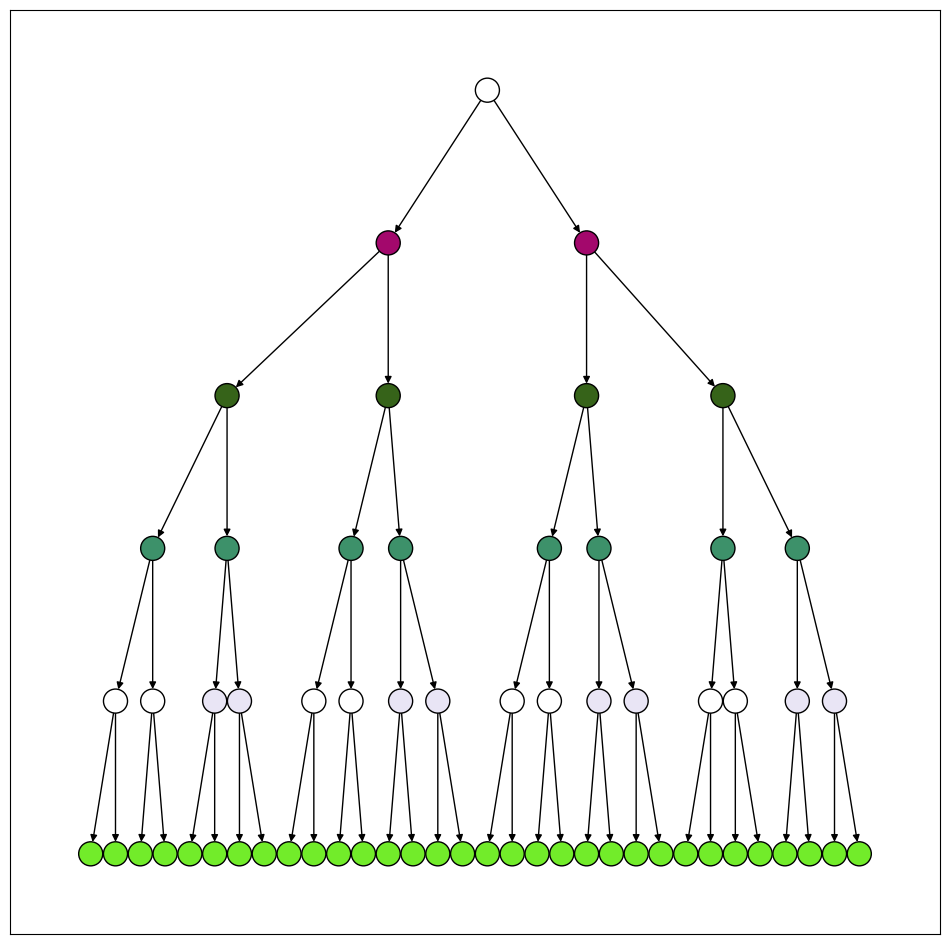

In [73]:
# We first set the number of variables
p = 6

# Next we need the dictionary of variables and the values they can take
# This must be in a dictionary of the form var:[vals] where var x_k ϵ [1,...,p]
# and each val ϵ [0,...,d_k]. Below is an example for 6 binary variables
vd = {i+1:[0,1] for i in range(p)}

# Ideally each CStree object is for an experiment, where we know variables
# and outcomes beforehand. Dataset is passed on during learning instead of 
# initial creation
rand_experiment = CStree(vd)

# To create a random CStree, we need an ordering, which must be a permutation
# of the variables, i.e. of [1,...,p]
order = [i+1 for i in range(p)]

# For each level k, we select two random nodes, and merge them with
# probability sparsity[k-1] and do this Ms[k-1] times ()
sp, M = 0.7, 3
sparsity = p*[sp]
Ms       = p*[5]
rand_tree, rand_tree_distr = rand_experiment.random_cstree(order, sparsity, Ms)

# We can first visualize this tree
rand_experiment.visualize(rand_tree, order)

Color count is  5


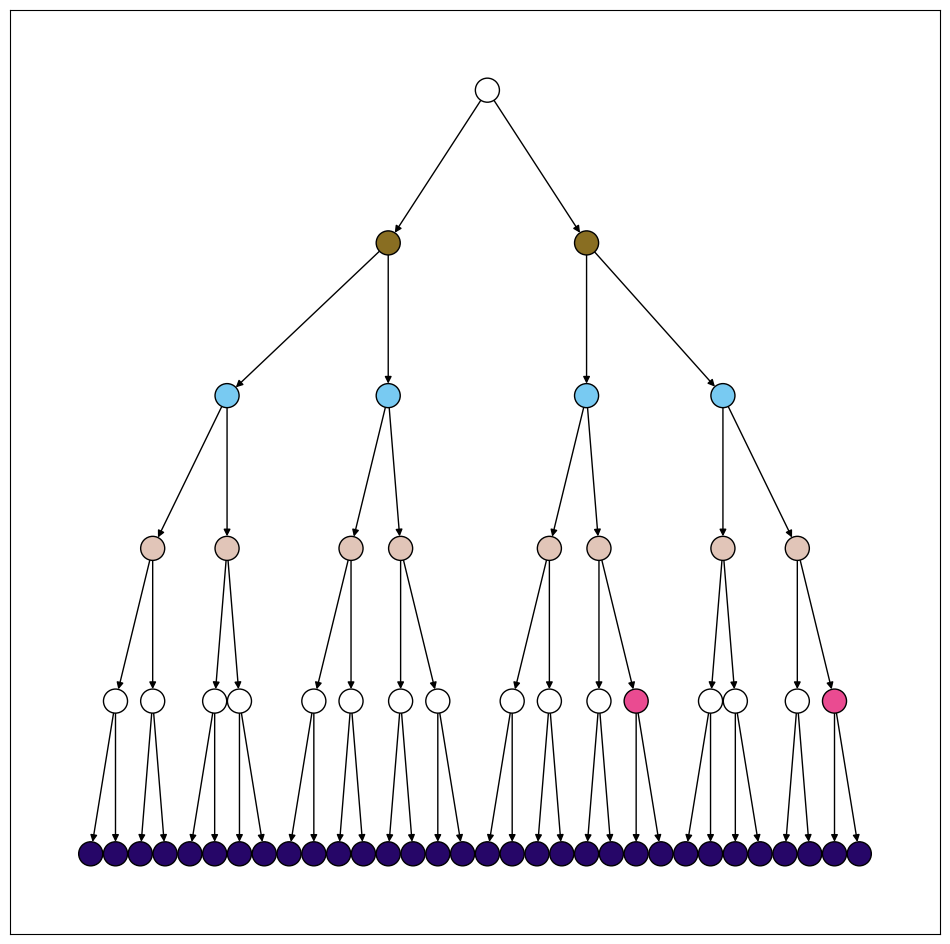

In [74]:
# Now to generate N samples, and put them in a numpy array since that is 
# what the CStree's learn_obs method takes as input
N = 10000

samples = np.array(rand_tree_distr.sample(N))

# Now to finally learn a CStree model from observational data
# The learn method takes a function that compares samples and returns True/False 
# depending on whether they are from the same distribution, and a scoring method
# which is either "bic" or "minstages". If we know possible orderings, they can be 
# passed on as a list of containing each order (which is itself a list). The 
# use_dag variable is either True or False depending on whether you want to use
# the DAG CI relations - in the case we give orderings, for each ordering we use 
# the DAG CI relations only if the ordering is consistent with the DAG otherwise
# we use the full DAG for that ordering.

# First we load the functions that compare samples, defined in tools.py
from code.utils.tools import test_anderson_k, test_epps, test_skl_divergence

# These functions should be passed after partially applying the parameters, 
# for example for the Hypothesis tests, they are the significance value
significance_lvl = 0.05
ak = lambda samples1,samples2,o: test_anderson_k(samples1,samples2,o,significance_lvl)

# for SKL, the parameters are the threshold
kl_threshold = 1e-5
skl = lambda samples1,samples2,o: test_skl_divergence(samples1,samples2,o,kl_threshold)

# The scoring method (bic/minstages) does not matter as they are used to choose
# the best order, and here we give the ordering
best_cstrees = rand_experiment.learn_obs(samples, skl, "bic", orders=[order], use_dag=True)

# The above result is a list containing the best (cstree,order) pair, where there could
# be multiple as per criteria, but as mentioned before here it doesnt matter since 
# we know the true ordering. Thus we extract the CStree learnt and visualize it below
tree_to_plot = best_cstrees[0][0]
rand_experiment.visualize(tree_to_plot,order)

In [87]:
# Now to make use of all of the above and show results for (diff)erent parameters

diff_p        = 7 # number of variables
diff_sps      = [0.2, 0.5, 0.8] # probability of merging 2 nodes
diff_M       = 4 # how many times nodes are merged per level
diff_numtrees = 100 # how many CStrees to generate for each (sp, M) pair
diff_Ns       = [1000] # Number of samples to generate for each CStree we generate

# CSI testing functions, note epps not included since it requires changing scipy source
# on local machine at the moment
diff_significance  = 0.01
diff_sklthreshold  = 1e-4
diff_ak  = lambda s1,s2,o: test_anderson_k(s1,s2,o,diff_significance)
diff_skl = lambda s1,s2,o: test_skl_divergence(s1,s2,o,diff_sklthreshold)

diff_order = [i+1 for i in range(diff_p)] # fix the order as [1,...,diff_p]

for s in diff_sps:
    for N in diff_Ns:
        # For each sp and N we record the following statistics
        ratio            = 0 # ratio of correct CStrees learnt
        matches          = 0 # number of stages in true CStree learnt from algorithm
        notin            = 0 # number of stages learnt from algorithm not in true CStree
        all_truestages   = 0 # total stages in all diff_numtrees CStrees generated
        all_learntstages = 0 # total stages in all diff_numtrees CStrees learnt
        for _ in range(diff_numtrees):
            t          = CStree({i+1:[0,1] for i in range(diff_p)}) # experiment with diff_p binary variables
        
            tree,distr = t.random_cstree(diff_order, diff_p*[s], diff_p*[diff_M]) # generate random tree and its corresponding distribution
            
            actual_stages = t.cstree_to_stages(tree) # get the stages of true tree
            
            all_truestages+=len(actual_stages)
            
            samples = np.array(distr.sample(N)) # generate N samples for tree generated above
            
            learnt_trees  = t.learn_obs(samples, diff_ak, "bic", orders=[diff_order], use_dag=False) # learn them from the data
            
            learnt_stages = t.cstree_to_stages(learnt_trees[0][0]) # extract the tree since the above gives list of (tree,order) pairs
            
            all_learntstages+=len(learnt_stages)
            
            # See how many stages we get
            # the stages are represented as a dictionary where the keys are the level, and the values are a set of 
            # sets (technically set of frozensets) where each set element is the context, which is a sequence of 
            # (variable, value) pairs. Here, we loop over all levels, and for each level, loop over the contexts
            # that fix the stages, and check if that context exists in the set of contexts for the learnt cstree 
            # in the same level (here we use that each stage is uniquely defined by the level and associated context)
            for level in actual_stages.keys():
                for context in actual_stages[level]:
                    if context in learnt_stages[level]:
                        matches+=1
                        
            # Here we count the stages learnt that are not in the true CStree
            for level in learnt_stages.keys():
                for context in learnt_stages[level]:
                    if context not in actual_stages[level]:
                        notin+=1
            
            if actual_stages==learnt_stages:
                ratio+=1/diff_numtrees
        
        #print("Prob of merging any 2 nodes",s,"Times merging done",M,"samples/tree",N, "CStree matches", ratio, "Stage matches", matches/all_truestages, "Extra stages", notin/all_learntstages)
        print("Merged random 2 nodes with probability {} {} times, {} trees with {} samples/tree - {} CStree match ratio, {} Stage match ratio, {} Extra stage ratio".format(s,diff_M,diff_numtrees, N, round(ratio,3), round(matches/all_truestages,3), round(notin/all_learntstages,3)))
        
        

Merged random 2 nodes with probability 0.2 4 times, 100 trees with 1000 samples/tree - 0 CStree match ratio, 0.245 Stage match ratio, 0.735 Extra stage ratio
Merged random 2 nodes with probability 0.5 4 times, 100 trees with 1000 samples/tree - 0.01 CStree match ratio, 0.522 Stage match ratio, 0.503 Extra stage ratio
Merged random 2 nodes with probability 0.8 4 times, 100 trees with 1000 samples/tree - 0.02 CStree match ratio, 0.642 Stage match ratio, 0.373 Extra stage ratio
